In [343]:
import pandas as pd
import seaborn as sns
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from typing import Dict, Union
from typing import Optional, Tuple

import joblib

In [344]:
TARGET_FEATURES = ['is_churn', 'is_keep','is_upgrade', 'churn_target', 'multiclass_target', 'churn_target_names', 'multiclass_target_names', 'churn_target']
IGNORE_FEATURES = ['gym', 'user', 'communication_date', 'heuristic_prediction']
TARGET = 'churn_target'
MULTI_CLASS_TARGET = "multiclass_target"

In [345]:
from helper import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [346]:
train = pd.read_parquet("data/train.parquet")
test = pd.read_parquet("data/test.parquet")
# train.head()

In [347]:
X_train = train.drop([TARGET],axis=1)
y_train = train[TARGET]
y_train2 = train[MULTI_CLASS_TARGET]

X_test = test.drop([TARGET],axis=1)
y_test = test[TARGET]

# Print the shapes of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (24913, 23) (24913,)
Testing set shape: (6348, 23) (6348,)


# Preprocessing

In [348]:
X_train

,communication_date,gym,gym_category,gym_days_since_first_visit,gym_last_60_days_visits,gyms_5km,user,user_age,months_usage,user_days_since_first_billing,...,user_last_60_days_visits,user_lifetime_visit_share,user_lifetime_visits,user_plan,years_usage,user_engagement,gym_visit_frequency,user_visit_frequency,user_age_group,multiclass_target
0,2021-10-25,0,bodybuilding,472,3751,35,0,50,13,1833.0,...,19.0,1.170213e+16,94.0,Silver,1.083333,7.230769,62.516667,0.316667,4,0
1,2021-06-20,1,not found,2176,357,7,1,45,87,2608.0,...,2.0,6.153846e+15,325.0,Basic II,7.250000,3.735632,5.950000,0.033333,4,0
3,2021-10-25,3,bodybuilding,896,4775,42,3,29,9,271.0,...,43.0,1.557789e+16,199.0,Basic I,0.750000,22.111111,79.583333,0.716667,2,0
4,2021-12-12,4,not found,1516,503,65,4,22,20,729.0,...,29.0,1.000000e+00,119.0,Silver,1.666667,5.950000,8.383333,0.483333,1,2
5,2021-06-19,5,bodybuilding,317,3986,27,5,57,11,684.0,...,8.0,1.282051e+15,78.0,Basic I,0.916667,7.090909,66.433333,0.133333,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31255,2022-02-02,74,bodybuilding,348,2880,3,31255,22,4,90.0,...,1.0,1.000000e+00,1.0,Basic I,0.333333,0.250000,48.000000,0.016667,1,0
31256,2021-12-04,19,not found,144,14979,28,31256,22,2,25.0,...,4.0,2.500000e-01,4.0,Silver,0.166667,2.000000,249.650000,0.066667,1,2
31257,2021-12-04,19,not found,144,14979,28,31257,66,1,19.0,...,1.0,1.000000e+00,1.0,Silver,0.083333,1.000000,249.650000,0.016667,6,1
31259,2022-01-17,50,crossfit,1500,780,30,31259,37,3,56.0,...,16.0,5.625000e+03,16.0,Silver,0.250000,5.333333,13.000000,0.266667,3,0


In [349]:
FEATURES = get_features(train, TARGET_FEATURES, IGNORE_FEATURES)
NUMERIC_FEATURES = sorted(get_numerical_features(train[FEATURES]))
CATEGORICAL_FEATURES = sorted(get_categorical_features(train[FEATURES]))
TARGET = "churn_target"
# FEATURES

In [350]:
USER_FEATURES = [k for k in NUMERIC_FEATURES if "user" in k]
USER_FEATURES = filter_list(USER_FEATURES, ['user_age_group'])

In [351]:
# Get the normalized value counts
counts = X_train['gym_category'].value_counts(normalize=True)

# Find the categories that constitute less than 0.01 of the data
small_categories = counts[counts < 0.01].index


In [352]:
X_train_feats = feat_engineering(X_train, small_categories, NUMERIC_FEATURES, USER_FEATURES)
X_train_feats.head()

/home/takano/miniconda3/envs/lightgbm/lib/python3.9/site-packages/pandas/core/groupby/generic.py:285: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f = lambda x: func(x, *args, **kwargs)


,communication_date,gym,gym_category,gym_days_since_first_visit,gym_last_60_days_visits,gyms_5km,user,user_age,months_usage,user_days_since_first_billing,...,gym_user_visit_frequency_max,gym_user_visit_frequency_median,gym_user_visit_frequency_average,gym_user_visit_frequency_std,gym_user_visit_frequency_var,gym_user_visit_frequency_ptp,gym_user_visit_frequency_skew,gym_user_visit_frequency_kurtosis,user_plan_price,total_revenue
0,2021-10-25,0,bodybuilding,472,3751,35,0,50,13,1833.0,...,0.850000,0.316667,0.346400,0.201834,0.040737,0.833333,0.404377,-0.656815,99.9,28671.3
1,2021-06-20,1,not found,2176,357,7,1,45,87,2608.0,...,0.600000,0.200000,0.262319,0.177113,0.031369,0.566667,0.593029,-0.703024,59.9,1377.7
2,2021-10-25,3,bodybuilding,896,4775,42,3,29,9,271.0,...,0.866667,0.300000,0.318824,0.201364,0.040548,0.850000,0.473950,-0.498566,39.9,10174.5
3,2021-12-12,4,not found,1516,503,65,4,22,20,729.0,...,0.800000,0.308333,0.327315,0.231529,0.053606,0.766667,0.435596,-0.813377,99.9,3596.4
4,2021-06-19,5,bodybuilding,317,3986,27,5,57,11,684.0,...,0.800000,0.183333,0.228896,0.183191,0.033559,0.783333,0.897420,0.214297,39.9,11690.7


In [353]:
X_test_feats = feat_engineering(X_test, small_categories, NUMERIC_FEATURES, USER_FEATURES)
X_test_feats.head()

/home/takano/miniconda3/envs/lightgbm/lib/python3.9/site-packages/pandas/core/groupby/generic.py:285: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f = lambda x: func(x, *args, **kwargs)


,communication_date,gym,gym_category,gym_days_since_first_visit,gym_last_60_days_visits,gyms_5km,user,user_age,months_usage,user_days_since_first_billing,...,gym_user_visit_frequency_max,gym_user_visit_frequency_median,gym_user_visit_frequency_average,gym_user_visit_frequency_std,gym_user_visit_frequency_var,gym_user_visit_frequency_ptp,gym_user_visit_frequency_skew,gym_user_visit_frequency_kurtosis,user_plan_price,total_revenue
0,2021-10-25,2,bodybuilding,895,3132,41,2,27,9,271.0,...,0.866667,0.250000,0.283498,0.188092,0.035379,0.850000,0.737913,0.055320,39.9,8059.8
1,2021-09-27,6,fight,679,72,91,6,25,45,2114.0,...,0.183333,0.066667,0.083333,0.053748,0.002889,0.150000,1.175826,0.097633,59.9,359.4
2,2021-08-07,10,crossfit,835,245,5,10,78,31,889.0,...,0.650000,0.216667,0.300000,0.198186,0.039278,0.633333,0.567378,-0.810922,99.9,1098.9
3,2021-06-13,24,functional,1530,366,10,24,20,46,1411.0,...,0.700000,0.250000,0.335294,0.167071,0.027913,0.566667,0.982291,0.123686,59.9,1018.3
4,2021-08-16,29,bodybuilding,2574,1186,16,30,21,35,1063.0,...,0.766667,0.241667,0.273990,0.188043,0.035360,0.750000,0.515975,-0.552309,59.9,3953.4


In [354]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [356]:
X_train_feats['total_revenue']

0        28671.3
1         1377.7
2        10174.5
3         3596.4
4        11690.7
          ...   
24908     8179.5
24909    88611.3
24910    88611.3
24911     3496.5
24912     6384.0
Name: total_revenue, Length: 24913, dtype: float64

# Model

In [358]:
FEATURES = get_features(X_train_feats, TARGET_FEATURES, IGNORE_FEATURES)
NUMERIC_FEATURES = sorted(get_numerical_features(X_train_feats[FEATURES]))
FEATURES_RAW = get_features(X_train, TARGET_FEATURES, IGNORE_FEATURES)
TARGET = "churn_target"
MULTI_CLASS_TARGET = "multiclass_target"

CATEGORICAL_FEATURES = sorted(get_categorical_features(X_train[FEATURES_RAW]))
CATEGORICAL_FEATURES

['gym_category', 'user_plan']

In [359]:

COLS_TO_INPUT = X_train_feats.columns[X_train_feats.isnull().any()]

In [360]:
show_null_values_df(X_train_feats)

,user_days_since_first_billing,user_last_60_days_visits,user_lifetime_visits,user_engagement,user_visit_frequency,last_60_user_visit_months_usage_ratio,last_60_user_visit_share_months_usage_ratio,last_60_user_visit_frequency,user_days_since_first_billing_log,user_engagement_log,...,gym_user_lifetime_visits_var,gym_user_lifetime_visits_ptp,gym_user_lifetime_visits_skew,gym_user_lifetime_visits_kurtosis,gym_user_visit_frequency_average,gym_user_visit_frequency_std,gym_user_visit_frequency_var,gym_user_visit_frequency_ptp,gym_user_visit_frequency_skew,gym_user_visit_frequency_kurtosis
1,2608.0,2.0,325.0,3.735632,0.033333,0.022989,0.022989,0.033333,7.866722,1.555115,...,42511.967532,NaN,NaN,NaN,0.262319,0.177113,0.031369,0.566667,0.593029,-0.703024
3,729.0,29.0,119.0,5.950000,0.483333,1.450000,1.450000,0.483333,6.593045,1.938742,...,5957.907143,288.0,0.524510,-0.702617,0.327315,0.231529,0.053606,0.766667,0.435596,-0.813377
8,2539.0,34.0,558.0,11.625000,0.566667,0.708333,0.708333,0.566667,7.839919,2.535679,...,25166.883333,NaN,NaN,NaN,0.298701,0.200689,0.040276,0.833333,0.494305,-0.528773
16,67.0,36.0,40.0,13.333333,0.600000,12.000000,12.000000,0.600000,4.219508,2.662588,...,5443.428896,NaN,NaN,NaN,0.382995,0.210276,0.044216,0.933333,0.176123,-0.770708
31,1019.0,3.0,161.0,5.031250,0.050000,0.093750,0.093750,0.050000,6.927558,1.796954,...,10725.648780,NaN,NaN,NaN,0.335127,0.206372,0.042590,0.866667,0.462829,-0.524871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24901,28.0,7.0,7.0,3.500000,0.116667,3.500000,3.500000,0.116667,3.367296,1.504077,...,9575.520685,574.0,2.393581,6.396919,0.226115,0.168895,0.028526,0.666667,0.834198,-0.183142
24905,49.0,25.0,25.0,8.333333,0.416667,8.333333,8.333333,0.416667,3.912023,2.233592,...,5443.428896,NaN,NaN,NaN,0.382995,0.210276,0.044216,0.933333,0.176123,-0.770708
24906,7.0,6.0,6.0,6.000000,0.100000,6.000000,6.000000,0.100000,2.079442,1.945910,...,9575.520685,574.0,2.393581,6.396919,0.226115,0.168895,0.028526,0.666667,0.834198,-0.183142
24909,25.0,4.0,4.0,2.000000,0.066667,2.000000,2.000000,0.066667,3.258097,1.098612,...,5443.428896,NaN,NaN,NaN,0.382995,0.210276,0.044216,0.933333,0.176123,-0.770708


## No Optimized Model

In [361]:
from collections import Counter
# count examples in each class
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 4.719


In [362]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
# Define the pipeline
# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), COLS_TO_INPUT),
        ('cat', TargetEncoder(), CATEGORICAL_FEATURES)],remainder='passthrough')

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing (imputation + one-hot encoding)
    ('model', XGBClassifier(scale_pos_weight=estimate))  # Model
])

# Fit the pipeline to the training data
pipeline.fit(X_train_feats[FEATURES], y_train.reset_index(drop=True))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  Index(['user_days_since_first_billing', 'user_last_60_days_visits',
       'user_lifetime_visits', 'user_engagement', 'user_visit_frequency',
       'last_60_user_visit_months_usage_ratio',
       'last_60_user_visit_share_months_usage_ratio',
       'last_...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [363]:
from collections import Counter
from sklearn.metrics import classification_report
y_pred_class = pipeline.predict(X_test_feats[FEATURES])
y_pred_proba = pipeline.predict_proba(X_test_feats[FEATURES])[:,1]

Precision-Recall AUC: 0.2372910212152839
classification_report
              precision    recall  f1-score   support

           0       0.89      0.62      0.73      5343
           1       0.23      0.59      0.33      1005

    accuracy                           0.62      6348
   macro avg       0.56      0.61      0.53      6348
weighted avg       0.79      0.62      0.67      6348


Best F1-score: 0.32947019867549665 at threshold 0.3270033001899719


/home/takano/projects/gympass-test/notebooks/helper.py:222: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*precision*recall / (precision + recall)


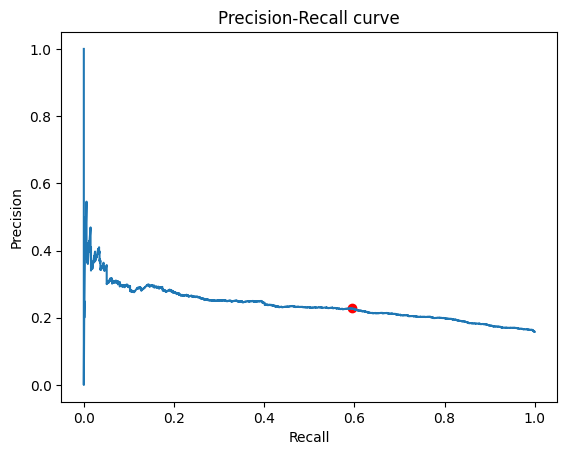

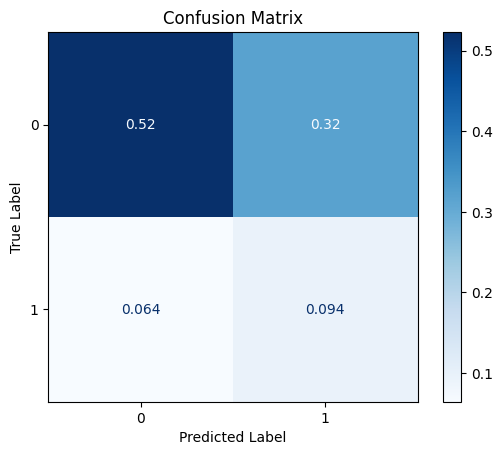

0.3270033

In [364]:
evaluate_metrics(y_test, y_pred_proba,normalize='all')

# Optimize Model

In [365]:
def get_params(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 6, 10),
        'subsample': trial.suggest_loguniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.5, 1.0),
        'tree_method': 'gpu_hist',
        'gpu_id': 0,
        'random_state': 42
    }
    
    return params


study = optmize_model(X_train_feats[FEATURES],y_train.reset_index(drop=True), preprocessor, XGBClassifier, get_params, n_trials=20, balance_feat='scale_pos_weight', n_splits=5)


[I 2023-07-15 13:53:12,072] A new study created in memory with name: no-name-df620a76-b5e3-4342-8319-bcdcfaff9205


/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_13189/1473360640.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: su

avg roc: 0.700708302555905
avg f1: 0.5780069718683585


/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_13189/1473360640.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: su

avg roc: 0.6831008651387518
avg f1: 0.5529498768279886


/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_13189/1473360640.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: su

avg roc: 0.61851210590125
avg f1: 0.4770910953602419


/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_13189/1473360640.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: su

avg roc: 0.6743267583844407
avg f1: 0.5591344470604434


/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_13189/1473360640.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: su

avg roc: 0.7026507963309607
avg f1: 0.5860728668881177


/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_13189/1473360640.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: su

avg roc: 0.6787688107860266
avg f1: 0.5645037734490141


/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_13189/1473360640.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: su

avg roc: 0.6885762266102401
avg f1: 0.5671880230402689


/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_13189/1473360640.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: su

avg roc: 0.6985216882008037
avg f1: 0.5795816968848525


/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_13189/1473360640.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: su

avg roc: 0.6993590336708616
avg f1: 0.5814412760343581


/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_13189/1473360640.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: su

avg roc: 0.7008109916977963
avg f1: 0.597210520063027


/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_13189/1473360640.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: su

avg roc: 0.703134301862695
avg f1: 0.6061447860141322


/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_13189/1473360640.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: su

avg roc: 0.7035800779002293
avg f1: 0.6032700244693607


/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_13189/1473360640.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: su

avg roc: 0.7046118413134914
avg f1: 0.6056416986868027


/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_13189/1473360640.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: su

avg roc: 0.7035557171038003
avg f1: 0.6050782144014041


/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_13189/1473360640.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: su

avg roc: 0.7030742498886341
avg f1: 0.5973776299758877


/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_13189/1473360640.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: su

avg roc: 0.7038855006218341
avg f1: 0.6025040959179219


/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_13189/1473360640.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: su

avg roc: 0.7000135067930917
avg f1: 0.5956109477874362


/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_13189/1473360640.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: su

avg roc: 0.7026799474948364
avg f1: 0.60095940911658


/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_13189/1473360640.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: su

avg roc: 0.6923861682483026
avg f1: 0.5638544169169544


/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_13189/1473360640.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.5, 1.0),
/tmp/ipykernel_13189/1473360640.py:4: FutureWarning: su

avg roc: 0.7019903214477734
avg f1: 0.5896908012072366
Number of finished trials: 20
Best trial: {'max_depth': 10, 'learning_rate': 0.005447688009831847, 'n_estimators': 660, 'min_child_weight': 7, 'subsample': 0.5009975752577268, 'colsample_bytree': 0.500527242209161}


In [366]:
joblib.dump(study.best_trial.params, "model/xgb_params.bin")

['model/xgb_params.bin']

## Optimized evaluation

In [367]:
import joblib

best_params = joblib.load("model/xgb_params.bin")
best_params

{'max_depth': 10,
 'learning_rate': 0.005447688009831847,
 'n_estimators': 660,
 'min_child_weight': 7,
 'subsample': 0.5009975752577268,
 'colsample_bytree': 0.500527242209161}

In [368]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
# Define the pipeline
# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), COLS_TO_INPUT),
        ('cat', TargetEncoder(), CATEGORICAL_FEATURES)],remainder='passthrough')

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing (imputation + one-hot encoding)
    ('model', XGBClassifier(**best_params))  # Model
])

# Fit the pipeline to the training data
pipeline.fit(X_train_feats[FEATURES], y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  Index(['user_days_since_first_billing', 'user_last_60_days_visits',
       'user_lifetime_visits', 'user_engagement', 'user_visit_frequency',
       'last_60_user_visit_months_usage_ratio',
       'last_60_user_visit_share_months_usage_ratio',
       'last_...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.005447688009831847, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=10,
                               max_leaves=None, min_child_weight=7, missing=nan,
                               monotone_constraints=None, n_estimators=660,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [369]:
y_pred_proba = pipeline.predict_proba(X_test_feats[FEATURES])[:,1]

Precision-Recall AUC: 0.2698551352106253
classification_report
              precision    recall  f1-score   support

           0       0.89      0.71      0.79      5343
           1       0.26      0.54      0.35      1005

    accuracy                           0.68      6348
   macro avg       0.58      0.63      0.57      6348
weighted avg       0.79      0.68      0.72      6348


Best F1-score: 0.3510570147341448 at threshold 0.19155746698379517


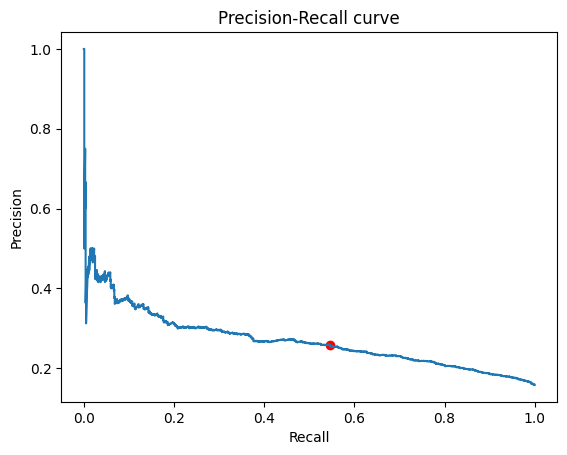

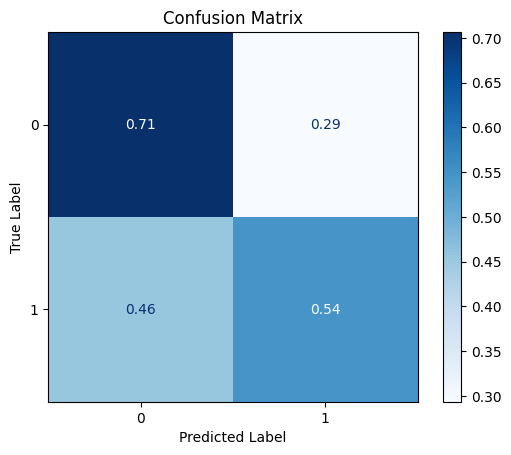

0.19155747

In [370]:
evaluate_metrics(y_test, y_pred_proba, normalize='true')

# Feature Selection

In [371]:
import joblib

best_params = joblib.load("model/xgb_params.bin")
best_params

{'max_depth': 10,
 'learning_rate': 0.005447688009831847,
 'n_estimators': 660,
 'min_child_weight': 7,
 'subsample': 0.5009975752577268,
 'colsample_bytree': 0.500527242209161}

In [372]:
best_params = dict(best_params, **{"gpu_id":0 , "tree_method": "gpu_hist", "random_state": 42})
best_params

{'max_depth': 10,
 'learning_rate': 0.005447688009831847,
 'n_estimators': 660,
 'min_child_weight': 7,
 'subsample': 0.5009975752577268,
 'colsample_bytree': 0.500527242209161,
 'gpu_id': 0,
 'tree_method': 'gpu_hist',
 'random_state': 42}

In [373]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train_sel, X_valid_sel, y_train_sel, y_valid_sel = train_test_split(X_train_feats, y_train, test_size=0.2, random_state=42)

In [374]:
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), COLS_TO_INPUT),
        ('cat', TargetEncoder(), CATEGORICAL_FEATURES)],remainder='passthrough')


model = XGBClassifier(**best_params)


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model),
])

f1_scores = []
recall_scores = []
precision_scores = []

X_train_sel = preprocessor.fit_transform(X_train_sel[FEATURES],y_train_sel)
X_valid_sel = preprocessor.transform(X_valid_sel[FEATURES])

STEP =8  

for k in range(2, X_train_sel.shape[1], STEP):
    selector = SelectKBest(score_func=f_classif, k=k)

    
    Xtrain2 = selector.fit_transform(X_train_sel, y_train_sel)
    Xval2 = selector.transform(X_valid_sel)
    model.fit(Xtrain2, y_train_sel)
    y_pred = model.predict(Xval2)
    
    f1 = f1_score(y_valid_sel, y_pred, average='macro')
    recall = recall_score(y_valid_sel, y_pred, pos_label=1)
    precision = precision_score(y_valid_sel, y_pred, pos_label=1)
    
    f1_scores.append(f1)
    recall_scores.append(recall)
    precision_scores.append(precision)
    
    print("k = {}, F1 Score = {}, Recall (Class 1) = {}, Precision (Class 1) = {}".format(k, f1, recall, precision))


/home/takano/miniconda3/envs/lightgbm/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


k = 2, F1 Score = 0.4547543494911916, Recall (Class 1) = 0.0, Precision (Class 1) = 0.0


/home/takano/miniconda3/envs/lightgbm/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


k = 10, F1 Score = 0.4547543494911916, Recall (Class 1) = 0.0, Precision (Class 1) = 0.0
k = 18, F1 Score = 0.4813229321682083, Recall (Class 1) = 0.02781136638452237, Precision (Class 1) = 0.5609756097560976
k = 26, F1 Score = 0.5121512854008592, Recall (Class 1) = 0.06287787182587666, Precision (Class 1) = 0.5977011494252874
k = 34, F1 Score = 0.5254531825317876, Recall (Class 1) = 0.07980652962515115, Precision (Class 1) = 0.584070796460177
k = 42, F1 Score = 0.5241447037247462, Recall (Class 1) = 0.07859733978234583, Precision (Class 1) = 0.5701754385964912
k = 50, F1 Score = 0.5263557618466821, Recall (Class 1) = 0.08101571946795647, Precision (Class 1) = 0.5826086956521739
k = 58, F1 Score = 0.5287640685564844, Recall (Class 1) = 0.08464328899637243, Precision (Class 1) = 0.5691056910569106
k = 66, F1 Score = 0.5319724406292359, Recall (Class 1) = 0.08827085852478839, Precision (Class 1) = 0.584
k = 74, F1 Score = 0.536613091272485, Recall (Class 1) = 0.094316807738815, Precision

In [375]:

# Print the best scores
best_k = (2 + f1_scores.index(max(f1_scores))) * 2
best_f1 = max(f1_scores)
best_recall = recall_scores[f1_scores.index(max(f1_scores))]
best_precision = precision_scores[f1_scores.index(max(f1_scores))]

print("Best k: {}, Best F1 Score: {}, Best Recall (Class 1): {}, Best Precision (Class 1): {}".format(
    best_k, best_f1, best_recall, best_precision))


Best k: 32, Best F1 Score: 0.5383308089212079, Best Recall (Class 1): 0.09673518742442563, Best Precision (Class 1): 0.583941605839416


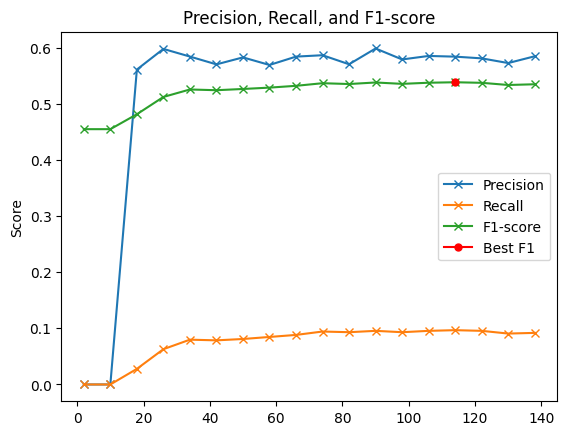

In [376]:
# Calculate the position of the best F1 score
xi=(list(range(2, X_train_sel.shape[1], STEP)))

best_index = np.argmax(f1_scores)
best_score = f1_scores[best_index]
best_position = xi[best_index]

# Plot precision
plt.plot(xi, precision_scores, label='Precision', marker='x')
# Plot recall
plt.plot(xi, recall_scores, label='Recall', marker='x')
# Plot F1-score
plt.plot(xi, f1_scores, label='F1-score', marker='x')
# Highlight the best F1 score
plt.plot(best_position, best_score, marker='o', markersize=5, color='red', label='Best F1')

# Set y-axis label
plt.ylabel('Score')

# Add legend
plt.legend()

# Add title
plt.title('Precision, Recall, and F1-score')

# Show the plot
plt.show()

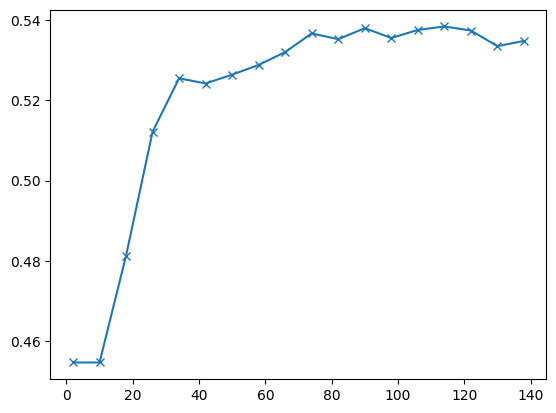

In [377]:
plt.plot(xi, f1_scores, label='F1-score', marker='x')

In [378]:
NUMBER_SEL_FEATS = 120
selector = SelectKBest(score_func=f_classif)
selector.fit(X_train_sel, y_train_sel)
mask = selector.get_support()

SELECTED_COLS = np.array(list(X_train_feats[FEATURES]))[mask]

In [379]:
from helper import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [380]:
COLS_TO_INPUT_SELECTED = list(set(SELECTED_COLS).intersection(COLS_TO_INPUT))

In [381]:
from collections import Counter
from sklearn.metrics import classification_report

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), COLS_TO_INPUT_SELECTED)
    ]
)


model = XGBClassifier(**best_params)


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model),
])

pipeline.fit(X_train_feats[SELECTED_COLS], y_train)
y_pred_proba = pipeline.predict_proba(X_test_feats[SELECTED_COLS])[:,1]

Precision-Recall AUC: 0.17872071544206564
classification_report
              precision    recall  f1-score   support

           0       0.90      0.09      0.16      5343
           1       0.16      0.95      0.28      1005

    accuracy                           0.22      6348
   macro avg       0.53      0.52      0.22      6348
weighted avg       0.78      0.22      0.18      6348


Best F1-score: 0.27973052138254245 at threshold 0.10512273758649826


/home/takano/projects/gympass-test/notebooks/helper.py:222: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*precision*recall / (precision + recall)


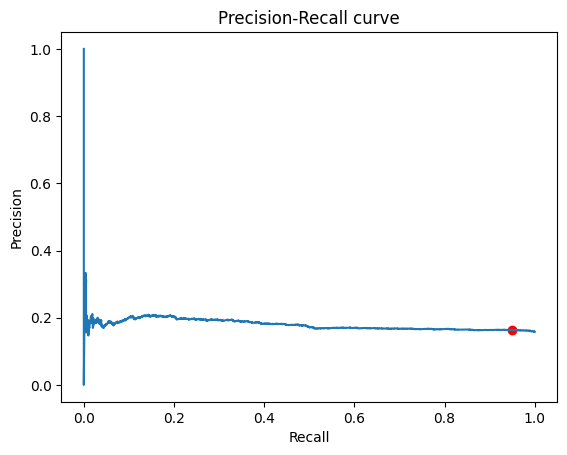

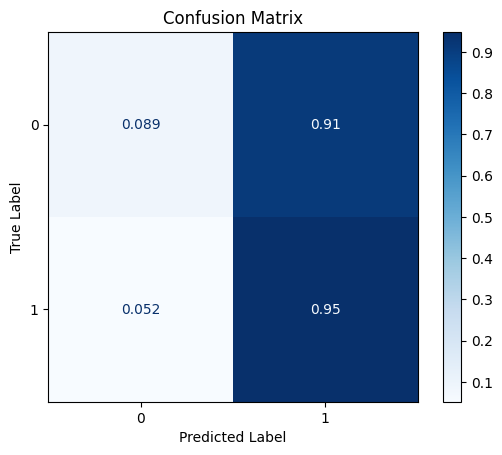

0.10512274

In [338]:
evaluate_metrics(y_test, y_pred_proba, normalize='true')

# Save assets

In [357]:
import joblib
CONFIG = {"cols_to_input":  COLS_TO_INPUT, "categorical_features":  CATEGORICAL_FEATURES, "features": FEATURES}

joblib.dump(CONFIG,"model/model_config.bin")

# save processed data

X_train_feats.to_parquet("data/X_train_feats.parquet")
pd.DataFrame(y_train).to_parquet("data/y_train_feats.parquet")

X_test_feats.to_parquet("data/X_test_feats.parquet")
pd.DataFrame(y_test).to_parquet("data/y_test_feats.parquet")

In [342]:
len(COLS_TO_INPUT)

74

# Conclusions
- I decided to not use the selected features as we lost too much recall, and with assumptions I made, I think is best to maintain a more complex model to avoid churn. However, it's hard to interpret. 
- XGBoost surpassed the baselines